In [3]:
import numpy as np
import pandas as pd
from simpeg.electromagnetics.static import utils as dc_utils
from simpeg.data import Data
# from simpeg import Solver

In [5]:
names = ['line', 'Ax', 'Az', 'Bx', 'Bz', 'Mx', 'Mz', 'Nx', 'Nz', 'AppRes']
df = pd.read_csv("../ert_data/cart tra_7.dat", skiprows=9, skipfooter=4, sep='\s+', header=None, names=names)

/var/folders/4m/sc07bkn154s8jfc7xp164by00000gq/T/ipykernel_73441/3522051604.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  df = pd.read_csv("../ert_data/cart tra_7.dat", skiprows=9, skipfooter=4, sep='\s+', header=None, names=names)


In [9]:
len(names)

10

In [10]:
df.head(3)

,line,Ax,Az,Bx,Bz,Mx,Mz,Nx,Nz,AppRes
0,4,46.0,0.0,44.0,0.0,48.0,0.0,50.0,0.0,16.97
1,4,46.0,0.0,44.0,0.0,50.0,0.0,52.0,0.0,12.19
2,4,46.0,0.0,44.0,0.0,52.0,0.0,54.0,0.0,9.09


In [12]:
df.to_csv("ert_data_cart_trail.csv", index=False)

In [13]:
locations_a = df[['Ax', 'Az']].values
locations_b = df[['Bx', 'Bz']].values
locations_m = df[['Mx', 'Mz']].values
locations_n = df[['Nx', 'Nz']].values

In [15]:
df.shape

(153, 10)

In [16]:
survey, sort_inds = dc_utils.generate_survey_from_abmn_locations(
    locations_a=locations_a,
    locations_b=locations_b,
    locations_m=locations_m,
    locations_n=locations_n,
    data_type='apparent_resistivity',
    output_sorting=True
)
survey.set_geometric_factor()

In [17]:
dobs = df['AppRes'].values[sort_inds]
standard_deviation = 0.05 * dobs 
data = Data(survey=survey, dobs=dobs, standard_deviation=standard_deviation)

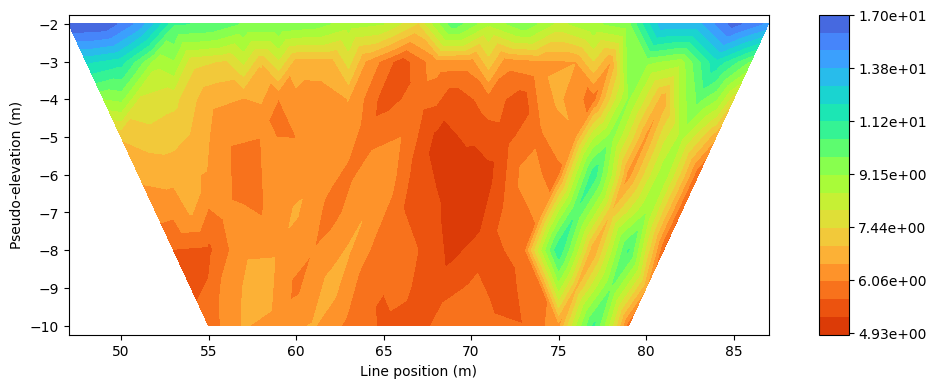

In [18]:
ax, out = dc_utils.plot_pseudosection(
    data, dobs=df['AppRes'].values[sort_inds], contourf_opts={'levels':20, 'cmap':'turbo_r'}, scale='log', clim=(4, 20)
)


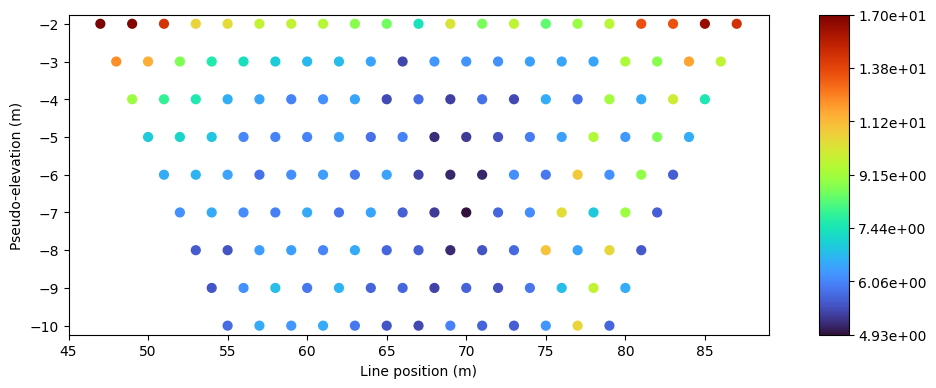

In [19]:
ax, out = dc_utils.plot_pseudosection(
    data, dobs=df['AppRes'].values[sort_inds], plot_type='scatter', scatter_opts={'cmap':'turbo'}, scale='log',
)

In [20]:
from discretize.utils import mesh_builder_xyz

In [22]:
mesh = mesh_builder_xyz(
    survey.unique_electrode_locations, [0.5, 0.2], depth_core=4, expansion_factor=1.2, padding_distance=[[30, 30], [20, 0.]]
)


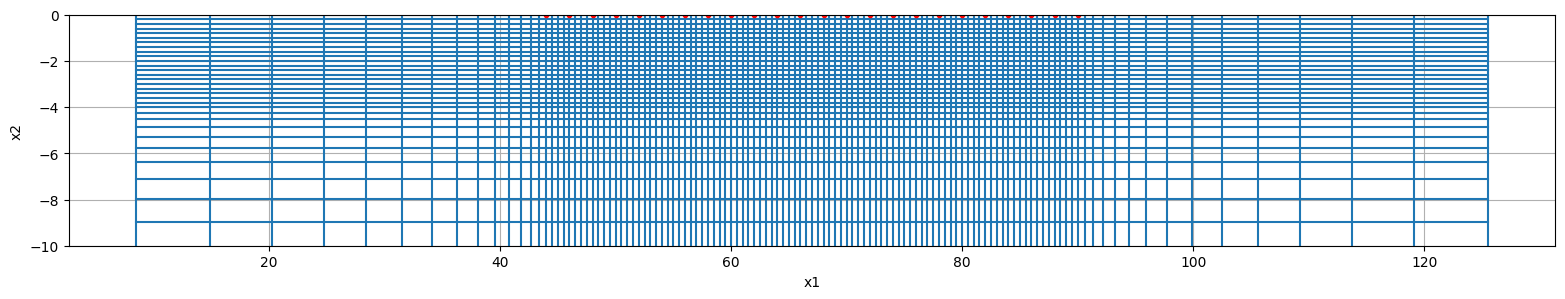

In [24]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1, figsize=(20, 3))
ax=mesh.plot_grid(ax=ax)
ax.plot(survey.unique_electrode_locations[:,0], survey.unique_electrode_locations[:,1], 'r.')
# ax.set_xlim(40, 95)
ax.set_ylim(-10, 0)
ax.set_aspect(2)

In [25]:
from simpeg.electromagnetics.static.resistivity import Simulation2DNodal
from simpeg import maps

In [26]:
sigmaMap = maps.ExpMap(mesh=mesh)

In [27]:
simulation = Simulation2DNodal(
    mesh=mesh,
    sigmaMap=sigmaMap,
    survey=survey, 
    storeJ=True
)

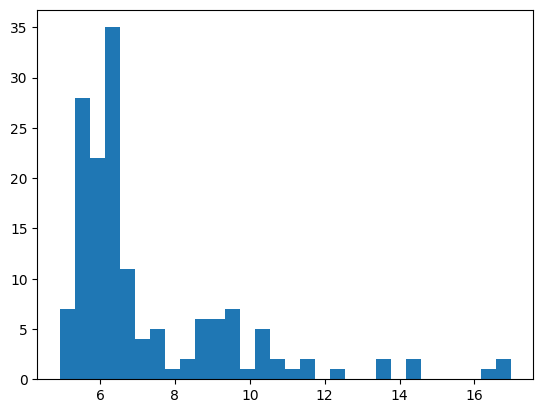

In [28]:
out = plt.hist(df['AppRes'].values[sort_inds], bins=30)

In [29]:
m0 = np.ones(mesh.n_cells) * np.log(1./6)

In [30]:
dpred = simulation.dpred(m0)

/Users/sgkang09/anaconda3/envs/em/lib/python3.11/site-packages/simpeg/simulation.py:197: DefaultSolverWarning: Using the default solver: Pardiso. 

If you would like to suppress this notification, add 
warnings.filterwarnings('ignore', simpeg.utils.solver_utils.DefaultSolverWarning)
 to your script.
  return get_default_solver(warn=True)


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [31]:
dobs = df['AppRes'].values[sort_inds]

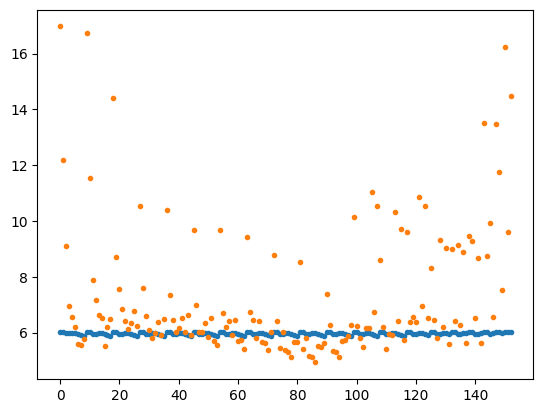

In [32]:
plt.plot(dpred, '.')
plt.plot(dobs, '.')

In [33]:
from simpeg import (
    maps,
    data_misfit,
    regularization,
    optimization,
    inverse_problem,
    inversion,
    directives,
)

In [34]:
1./0.5**2

4.0

In [35]:
dmis_L2 = data_misfit.L2DataMisfit(simulation=simulation, data=data)
reg_L2 = regularization.WeightedLeastSquares(
    mesh,
    alpha_s=1e-10,
    alpha_x=10.,
    alpha_y=1,
)
opt_L2 = optimization.InexactGaussNewton(
    maxIter=10, maxIterLS=20, maxIterCG=50, tolCG=1e-3
)
inv_prob_L2 = inverse_problem.BaseInvProblem(dmis_L2, reg_L2, opt_L2)
starting_beta = directives.BetaEstimate_ByEig(beta0_ratio=10)
beta_schedule = directives.BetaSchedule(coolingFactor=2.0, coolingRate=1)
target_misfit = directives.TargetMisfit(chifact=0.1)
save_dict = directives.SaveOutputDictEveryIteration()

directives_list_L2 = [
    starting_beta,
    beta_schedule,
    target_misfit,
    save_dict
]

# Here we combine the inverse problem and the set of directives
inv_L2 = inversion.BaseInversion(inv_prob_L2, directives_list_L2)

# Run the inversion
minv = inv_L2.run(m0)


Running inversion with SimPEG v0.23.0
simpeg.InvProblem will set Regularization.reference_model to m0.
simpeg.InvProblem will set Regularization.reference_model to m0.
simpeg.InvProblem will set Regularization.reference_model to m0.
simpeg.InvProblem will set Regularization.reference_model to m0.
simpeg.InvProblem will set Regularization.reference_model to m0.

                        simpeg.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                        ***Done using same Solver, and solver_opts as the Simulation2DNodal problem***
                        


/Users/sgkang09/anaconda3/envs/em/lib/python3.11/site-packages/pymatsolver/solvers.py:415: FutureWarning: In Future pymatsolver v0.4.0, passing a vector of shape (n, 1) to the solve method will return an array with shape (n, 1), instead of always returning a flattened array. This is to be consistent with numpy.linalg.solve broadcasting.
  return self.solve(val)


model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  1.02e+01  3.32e+03  0.00e+00  3.32e+03    4.72e+02      0              
   1  5.09e+00  3.67e+02  3.17e+01  5.28e+02    1.54e+02      0              
   2  2.55e+00  2.02e+02  3.56e+01  2.93e+02    3.38e+01      0              
   3  1.27e+00  1.61e+02  4.64e+01  2.20e+02    2.60e+01      0   Skip BFGS  
   4  6.37e-01  1.36e+02  5.97e+01  1.74e+02    2.13e+01      0   Skip BFGS  
   5  3.18e-01  1.21e+02  7.56e+01  1.45e+02    1.61e+01      0   Skip BFGS  
   6  1.59e-01  1.10e+02  9.90e+01  1.26e+02    1.23e+01      0   Skip BFGS  
   7  7.96e-02  1.00e+02  1.39e+02  1.11e+02    1.62e+01      0   Skip BFGS  
   8  3.98e-02  9.25e+01  2.05e+02  1.01e+02    2.34e+01      0   Skip BFGS  
   9  1.99e-02  8.72e+01

In [36]:
xmin, xmax = survey.unique_electrode_locations[:,0].min(), survey.unique_electrode_locations[:,0].max()

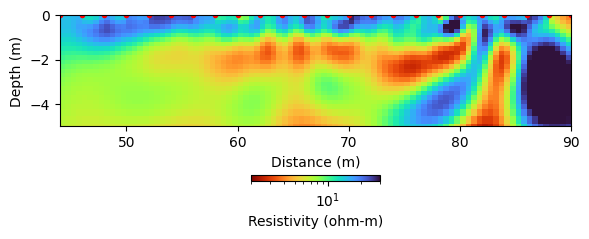

In [45]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
iteration = 10
minv = save_dict.outDict[iteration]['m']
dpred = save_dict.outDict[iteration]['dpred']
sigma = np.exp(minv)
fig, ax = plt.subplots(1,1, figsize=(6, 4))
out=mesh.plot_image(1./sigma, ax=ax, pcolor_opts = {'cmap':'turbo_r', 'norm':LogNorm(vmin=2, vmax=30)})
ax.plot(survey.unique_electrode_locations[:,0], survey.unique_electrode_locations[:,1], 'r.')
ax.set_xlim(xmin, xmax)
ax.set_ylim(-5, 0)
ax.set_aspect(2)
ax.set_xlabel("Distance (m)")
ax.set_ylabel("Depth (m)")
cb = plt.colorbar(out[0], orientation='horizontal', fraction=0.02)
cb.set_label("Resistivity (ohm-m)")
plt.tight_layout()


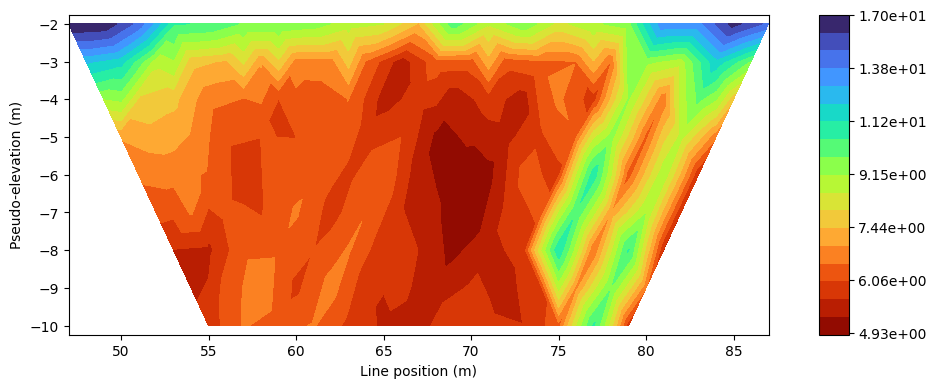

In [46]:
ax, out = dc_utils.plot_pseudosection(
    data, dobs=dobs, contourf_opts={'levels':20, 'cmap':'turbo_r'}, scale='log',
)

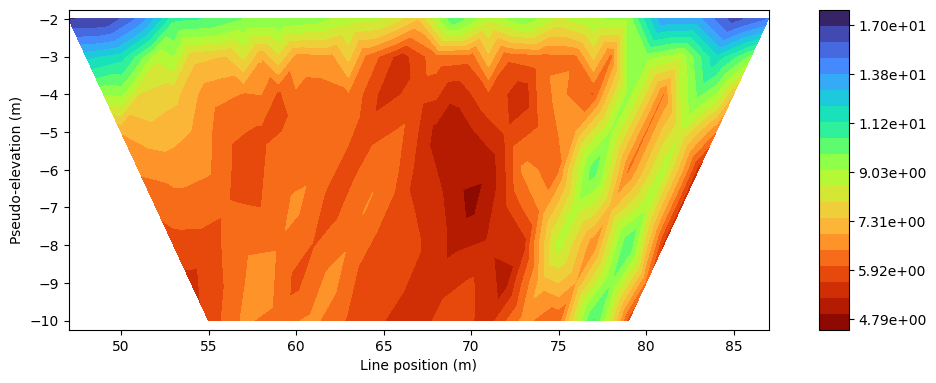

In [47]:
ax, out = dc_utils.plot_pseudosection(
    data, dobs=dpred, contourf_opts={'levels':20, 'cmap':'turbo_r'}, scale='log',
)

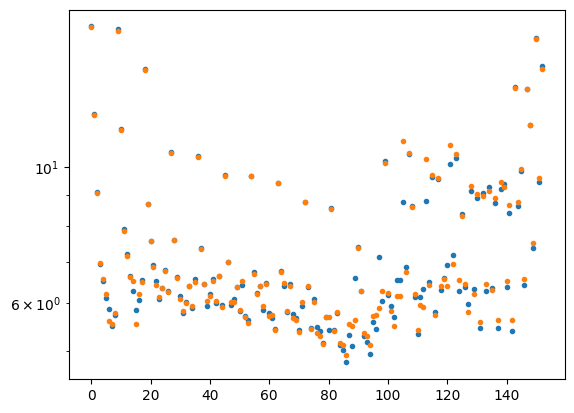

In [48]:
plt.semilogy(dpred, '.')
plt.semilogy(dobs, '.')